# This is a practice notebook for debugging issues with the astrotog package. 

In [1]:
%matplotlib inline
import numpy as np
import sncosmo
from math import inf
from astropy.cosmology import Planck15 as cosmo
from astrotog import transient_obs_dist as tod
import matplotlib.pyplot as plt
from copy import deepcopy

## Define the general file paths and parameters

### Survey and SED file paths

In [2]:
surveydb_path = '/Users/cnsetzer/Documents/LSST/surveydbs/minion_1016_sqlite.db'
fields = ['fieldID', 'fieldRA', 'fieldDec', 'filter', 'expMJD', 'fiveSigmaDepth']
db_flag = 'wfd'
sedsdb_path = "../sedb/rosswog/NSNS/winds"
gen_flag = 'cycle'

In [3]:
param_priors = {'zmin': 0.0, 'zmax': 0.1, 'cosmology': cosmo,
                'kappa_min': 1, 'kappa_max': 10, 'm_ej_min': 0.01,
                'm_ej_max': 0.2, 'v_ej_min': 0.01, 'v_ej_max': 0.5}
instrument_params = {'FOV_rad': np.deg2rad(1.75), 'Mag_Sys': 'ab', 'Instrument': 'lsst'}
Cuts = {'SNR': {'upper': inf, 'lower': 5}}
z0 = 0.00000225975 #redshift of 10pc for purpose of placing the SEDs
z1 = 1.0

## Get the SEDs from the provided data files and create data construct

In [4]:
sed_db = tod.Get_SEDdb(sedsdb_path)

### Get a small subset (one sed) to work with and debug with

In [5]:
test_sed = {}
test_key = 'SED_wind16'
test_model = deepcopy(sed_db[test_key]['model'])
test_sed[test_key] = deepcopy(sed_db[test_key])

In [6]:
lsst_bands = ['lsstg', 'lsstr', 'lssti', 'lsstz']

### Plot some of the lightcurves of this SED to get an idea of what's going on

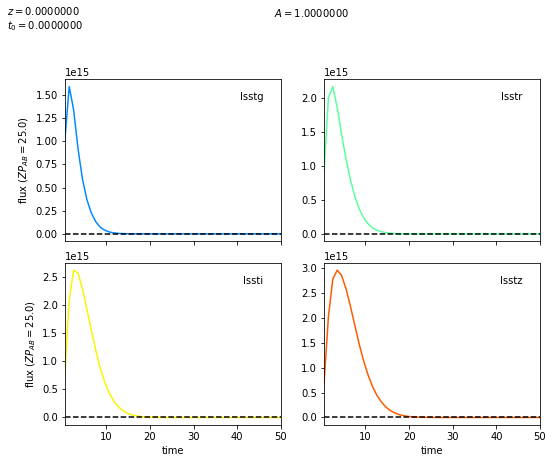

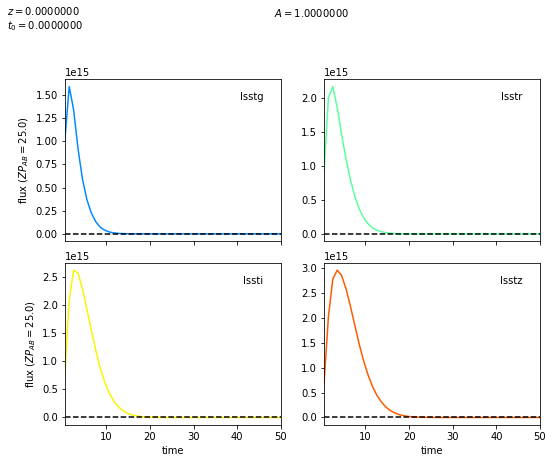

In [7]:
sncosmo.plot_lc(model = test_sed[test_key]['model'], bands = lsst_bands)

### Setup the wavelengths and time for SED comparison before and after redshifting

In [8]:
wavelengths = np.linspace(test_model.minwave()+1000,test_model.maxwave()-1000,100)
time_red_compare = 3.0

### Output a flux to compare with .dat file to make sure data is read in correctly

In [9]:
pre_z_flux = deepcopy(test_model.flux(time_red_compare,wavelengths))

In [10]:
R_Abs_Mag = deepcopy(test_model.bandmag('lsstr','ab',time_red_compare))

## Begin to investigate how setting the redshift affects the model and flux/amplitudes

In [11]:
test_model_only_z = deepcopy(test_sed[test_key]['model'])
test_model_only_z.set(z = z1)
test_sed_z_and_amp = deepcopy(tod.Set_SED_Redshift(test_sed, [z1],cosmo))

In [12]:
post_z_flux_only_z = deepcopy(test_model_only_z.flux(time_red_compare, wavelengths))
post_z_flux_both = deepcopy(test_sed_z_and_amp[test_key]['model'].flux(time_red_compare,wavelengths))

### Plot new lightcurves and plot the fluxes from the different redshifting methods

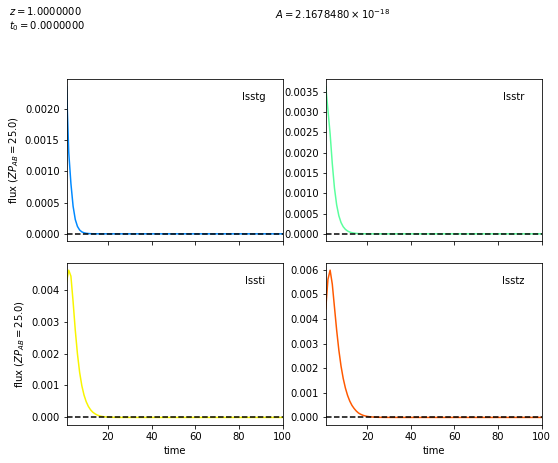

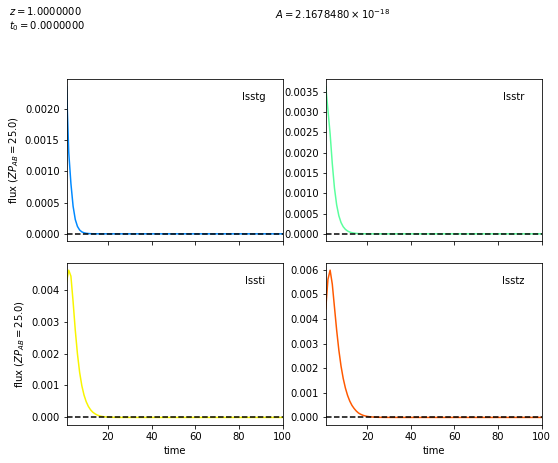

In [13]:
sncosmo.plot_lc(model = test_sed[test_key]['model'], bands = lsst_bands)

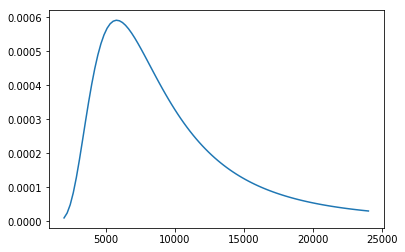

In [14]:
plt.plot(wavelengths,pre_z_flux)

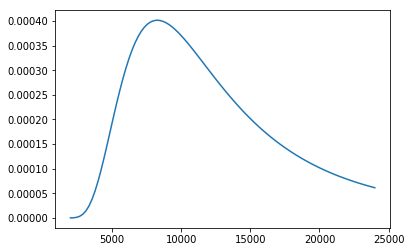

In [15]:
plt.plot(wavelengths,post_z_flux_only_z)

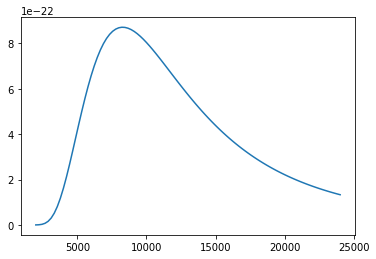

In [16]:
plt.plot(wavelengths,post_z_flux_both)

In [17]:
test_model.bandmag('lsstr','ab',time_red_compare)

-13.279670967614825

## Do the apparent magnitude calculation manually to compare the output from the code

In [18]:
lum_dist_Mpc = cosmo.luminosity_distance(z1).value
lum_dist_pc = lum_dist_Mpc * 1e6

In [19]:
R_app_mag_straightforward = R_Abs_Mag + 5*np.log10(lum_dist_pc) - 5
R_app_mag_code_both = test_sed_z_and_amp[test_key]['model'].bandmag('lsstr','ab',time_red_compare)
R_app_mag_code_z = test_model_only_z.bandmag('lsstr','ab',time_red_compare)
R_app_mag_code_z_plus_shift = R_app_mag_code_z + 5*np.log10(lum_dist_pc) - 5
print(R_app_mag_straightforward,R_app_mag_code_z, R_app_mag_code_both, R_app_mag_code_z_plus_shift)

30.8802569392 -12.6406014374 31.5193264694 31.5193264694


### Something odd seems to be happening with how sncosmo sets the magnitude

In [20]:
cosmo.distmod(z1).value + R_app_mag_code_z

31.519326469376736

# With the magnitude issues resolved move forward with placing the SEDs

In [ ]:
tsed_z = test_sed_z_and_amp

### Get the survey database and paramters

In [ ]:
obs_database = tod.Get_ObsStratDB_Summary(surveydb_path, db_flag)
survey_params = tod.Get_Survey_Params(obs_database)

 Using OpSimOutput tool to get the database of simulated survey observations.
 reading from database sqlite:////Users/cnsetzer/Documents/LSST/surveydbs/minion_1016_sqlite.db
SELECT * FROM Summary WHERE PROPID in (54)


### Using the z-placed SED from above put the test_SED at a RA, Dec, and MJD within the survey

In [ ]:
key_list = tsed_z.keys()
N_SEDs = len(tsed_z)
RA_dist, Dec_dist = tod.Ra_Dec_Dist(N_SEDs, survey_params)
t_dist = tod.Time_Dist(N_SEDs, survey_params)
for i, key in enumerate(key_list):
    tsed_z[key]['parameters']['z'] = tsed_z[key]['model'].get('z')
    tsed_z[key]['parameters']['ra'] = RA_dist[i]
    tsed_z[key]['parameters']['dec'] = Dec_dist[i]
    tsed_z[key]['parameters']['min_MJD'] = t_dist[i]
    tsed_z[key]['parameters']['max_MJD'] = t_dist[i] + tsed_z[key]['model'].maxtime()

In [ ]:
print(tsed_z[key]['parameters'])

### With this single SED try to use the generate observations functions

In [ ]:
print(' Getting the LSST throughputs and computing the reference fluxes...')
instrument_params = tod.Get_Throughputs(instrument_params)
instrument_params = tod.Get_Reference_Flux(instrument_params)
print(' Done computing instrument parameters.')
print(instrument_params)

In [ ]:
matched_obs_db = tod.Match_Event_to_Obs(tsed_z[key], obs_database, instrument_params)

In [ ]:
print(matched_obs_db['expMJD'].unique())

In [ ]:
All_Source_Observations = tod.Gen_Observations(tsed_z, obs_database, instrument_params)

In [ ]:
print(All_Source_Observations[key]['observations']['lsstz']['magnitudes'])

In [ ]:
All_Source_Observations = tod.Assign_SNR(All_Source_Observations)

In [ ]:
print(All_Source_Observations[key]['observations']['lsstz'])

In [ ]:
All_Source_Observations, Detections, n_detect, efficiency = tod.Get_Detections(All_Source_Observations, Cuts)

In [ ]:
# Plot the lightcurve results
figure = tod.Plot_Observations(Detections)
# For the first run show only one plot
plt.show()

In [ ]:
obs_key = 'observations'
band = 'lsstz'
times = deepcopy(All_Source_Observations[key][obs_key][band]['times'])
mags = deepcopy(All_Source_Observations[key][obs_key][band]['magnitudes'])
errs = deepcopy(All_Source_Observations[key][obs_key][band]['mag_errors'])

In [ ]:
print(times,mags,errs)

In [ ]:
errs = np.ones_like(errs)

In [ ]:
print(times,mags,errs)

In [ ]:
All_Source_Observations[key][obs_key][band]['mag_errors'] = errs

In [ ]:
print(All_Source_Observations[key][obs_key][band]['mag_errors'])

# Try to work with the actual generating script

In [2]:
import numpy as np
from math import inf
import matplotlib.pyplot as plt
from astrotog import transient_obs_dist as tod
import seaborn
# Import a cosmology, comment out if you want to define your own per the
# astropy cosmology class
from astropy.cosmology import Planck15 as cosmo

# Define directory for locations of SEDS, references, throughputs
paths = {}
paths['seds'] = '/Users/cnsetzer/Documents/LSST/astrotog/sedb/rosswog/NSNS/winds'
paths['survey'] = '/Users/cnsetzer/Documents/LSST/surveydbs/minion_1016_sqlite.db'
paths['throughputs'] = '/Users/cnsetzer/Documents/LSST/astrotog/throughputs'
paths['references'] = '/Users/cnsetzer/Documents/LSST/astrotog/throughputs/references'
# Relevant fields in the survey database
fields = ['fieldID', 'fieldRA', 'fieldDec', 'filter', 'expMJD', 'fiveSigmaDepth']
# Flag for the survey database retreival to only get a subset of the whole.
db_flag = 'wfd'
# Parameter prior for generating the transient KNe distribution
param_priors = {'zmin': 0.0, 'zmax': 0.15, 'z_bin_size': 0.01, 'rate': 500.0,
                'cosmology': cosmo, 'kappa_min': 1, 'kappa_max': 10,
                'm_ej_min': 0.01, 'm_ej_max': 0.2, 'v_ej_min': 0.01, 'v_ej_max': 0.5}
instrument_params = {'Instrument': 'lsst', 'FOV_rad': np.deg2rad(1.75), 'Mag_Sys': 'ab'}
# Different selections cuts and corresponding limits
Cuts = {'SNR': {'upper': inf, 'lower': 5, 'limit': 0.5}}
# Flag for SED generation to just cycle through SEDs in the database
gen_flag = 'cycle'

# Initialize the figure number for iterative, functional plotting
fig_num = 1
# Setup the basic running structure
print(' ')
obs_database = tod.Get_ObsStratDB_Summary(paths['survey'], db_flag)
print(' Done reading in observation databse: {}'.format(paths['survey']))
print('\n Getting survey paramters...')
survey_params = tod.Get_Survey_Params(obs_database)
print(' Done retreiving survey paramters.')
# Generate the all mock KNe SEDs
print('\n Generating mock KNe sources...')
SEDs = tod.Gen_SED_dist(paths['seds'], survey_params, param_priors, gen_flag)
print(' Done generating mock KNe sources.')
print(' Getting the LSST throughputs and computing the reference fluxes...')
instrument_params = tod.Get_Throughputs(instrument_params, paths)
instrument_params = tod.Get_Reference_Flux(instrument_params, paths)
print(' Done computing instrument parameters.')

 
 Using OpSimOutput tool to get the database of simulated survey observations.
 reading from database sqlite:////Users/cnsetzer/Documents/LSST/surveydbs/minion_1016_sqlite.db
SELECT * FROM Summary WHERE PROPID in (54)
 Done reading in observation databse: /Users/cnsetzer/Documents/LSST/surveydbs/minion_1016_sqlite.db

 Getting survey paramters...
 Done retreiving survey paramters.

 Generating mock KNe sources...
 The number of mock SEDs being genereated is 2245
 The number of SEDs in Database is 23
 Done generating mock KNe sources.
 Getting the LSST throughputs and computing the reference fluxes...
 Done computing instrument parameters.


In [3]:
# Apply observation to all mock SEDs
print('\n Applying simulated observations to mock sources...')
All_Source_Observations = tod.Gen_Observations(SEDs, obs_database, instrument_params)
print(' Done generating simulated observations of mock sources.')

# Add quality of observation information, currently just SNR
All_Source_Observations = tod.Assign_SNR(All_Source_Observations)
# Using this quality assignment and predefined selection cut criteria determine
# 'detections'
All_Source_Observations, Detections, n_detect, efficiency = tod.Get_Detections(All_Source_Observations, Cuts)
print('\n The number of detected KNe is {2} for a {0} cut of {1}.\n This is an efficiency of {3:.3f}%'
      .format('SNR', Cuts['SNR']['lower'], n_detect, 100*efficiency))
print('The number of mock sources is {0}, and the number of observed sources is \
        {1}'.format(len(SEDs.keys()), len(Detections.keys())))


 Applying simulated observations to mock sources...
 Done generating simulated observations of mock sources.

 The number of detected KNe is 83 for a SNR cut of 5.
 This is an efficiency of 3.697%
The number of mock sources is 2245, and the number of observed sources is         83


The redshift range of all sources is 0.0107 to 0.1500.
The redshift range of the detected sources is 0.0108 to 0.1347.


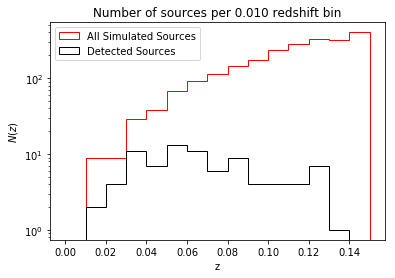

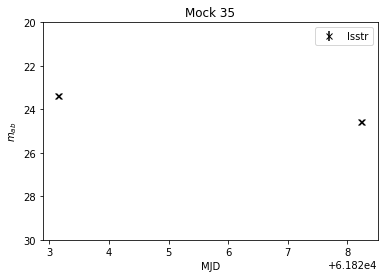

In [4]:
# Plot histogram of detected vs genereated mock KNe
N_z_fig, fig_num = tod.Get_N_z(SEDs, Detections, param_priors, fig_num)

# Plot the lightcurve results
Lightcurve_fig, fig_num = tod.Plot_Observations(Detections, fig_num)
# For the first run show only one plot
#plt.ion()
plt.show()

## Try to figure out histogram and errorbar problems (Resolved)

In [5]:
param_key = 'parameters'
z_min = param_priors['zmin']
z_max = param_priors['zmax']
all_zs, detect_zs = [], []
mock_all_keys = SEDs.keys()
mock_detect_keys = Detections.keys()
for key in mock_all_keys:
    all_zs.append(SEDs[key][param_key]['z'])
for key in mock_detect_keys:
    detect_zs.append(Detections[key][param_key]['z'])
print('The redshift range of all sources is {0:.4f} to {1:.4f}.'.format(min(all_zs),max(all_zs)))
print('The redshift range of the detected sources is {0:.4f} to {1:.4f}.'.format(min(detect_zs),max(detect_zs)))
all_z_hist, all_z_bins = np.histogram(a=all_zs, bins=10, range=(z_min, z_max))
bin_size = abs(all_z_bins[1]-all_z_bins[0])
detect_z_hist, detect_z_bins = np.histogram(a=detect_zs, bins=all_z_bins)

The redshift range of all sources is 0.0107 to 0.1500.
The redshift range of the detected sources is 0.0108 to 0.1347.


## Alternate histogram method

Text(0.5,1,'Number per 0.0150 redshift bin')

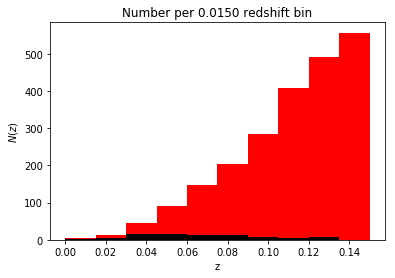

In [6]:
N_z_dist_fig = plt.figure()
plt.bar(all_z_bins[:-1], all_z_hist, width = np.diff(all_z_bins), align='edge', color='red', label='All')
plt.bar(detect_z_bins[:-1], detect_z_hist, width = np.diff(detect_z_bins), align='edge', color='black', label='Detected')
plt.xlabel('z')
plt.ylabel(r'$N(z)$')
plt.title('Number per {0:.4f} redshift bin'.format(bin_size))

In [7]:
print(Detections)

{'Mock 35': {'model': <sncosmo.models.Model object at 0x1a1c093c88>, 'parameters': {'kappa': 1.0, 'm_ej': 0.05, 'v_ej': 0.1, 'z': 0.065769597283076631, 'ra': 2.9885731981590622, 'dec': -0.24878894376999244, 'min_MJD': 61821.440613548664, 'max_MJD': 61874.729093412818}, 'observations': {'lsstr': {'times': [61823.143082000002, 61823.156026999997, 61828.229913000003, 61828.253838999997], 'magnitudes': [23.388019490412674, 23.38367644198275, 24.58824069694154, 24.603304689190814], 'mag_errors': [2.0982038694826917e-07, 1.9759286768852196e-07, 5.412882082072386e-07, 5.503352906152563e-07], 'band_flux': [7.630759668917278e-16, 7.661344566262138e-16, 2.526267255983589e-16, 2.491458721286474e-16], 'flux_error': [8.529342763268807e-17, 8.064479968109116e-17, 7.284637874156768e-17, 7.304343146544659e-17], 'five_sigma_depth': [array([ 24.019725]), array([ 24.080573]), array([ 24.190994]), array([ 24.188061])], 'SNR': [array([ 8.94648026]), array([ 9.50010986]), array([ 3.46793801]), array([ 3.410

In [8]:
def Plot_Observations(Observations, fig_num):
    # Function to take the specific observation data structure and plot the
    # mock observations.
    obs_key = 'observations'
    source_list = Observations.keys()
    for key in source_list:
        band_keys = Observations[key][obs_key].keys()
        n_plots = len(band_keys)
        # Max 6-color lightcurves
        f = plt.figure(fig_num)
        for i, band in enumerate(band_keys):
            axes = f.add_subplot(n_plots, 1, i+1)
            times = deepcopy(Observations[key][obs_key][band]['times'])
            mags = deepcopy(Observations[key][obs_key][band]['magnitudes'])
            errs = deepcopy(Observations[key][obs_key][band]['mag_errors'])
            if n_plots > 1:
                axes[i].errorbar(x=times, y=mags, yerr=errs, fmt='kx')
                axes[i].legend(['{}'.format(band)])
                axes[i].set(xlabel='MJD', ylabel=r'$m_{ab}$')
                axes[i].set_ylim(bottom=np.ceil(max(mags)/10.0)*10.0, top=np.floor(min(mags)/10.0)*10.0)
            else:
                axes.errorbar(x=times, y=mags, yerr=errs, fmt='kx')
                axes.legend(['{}'.format(band)])
                axes.set(xlabel='MJD', ylabel=r'$m_{ab}$')
                axes.set_ylim(bottom=np.ceil(max(mags)/10.0)*10.0, top=np.floor(min(mags)/10.0)*10.0)
        if n_plots > 1:
            axes[0].set_title('Source, {}'.format(key))
        else:
            axes.set_title('{}'.format(key))
        # Break to only do one plot at the moment
        fig_num += 1
        break
    return f, fig_num

In [9]:
well_detected = {}
well_detected['Mock 58'] = deepcopy(Detections['Mock 58'])

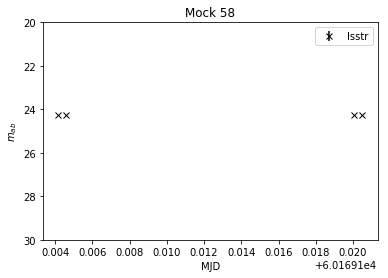

In [10]:
f, fig_num = Plot_Observations(well_detected, 1)

In [24]:
(60*24/10000)*5*60

43.199999999999996

In [11]:
Detections.keys()

dict_keys(['Mock 35', 'Mock 58', 'Mock 61', 'Mock 67', 'Mock 80', 'Mock 101', 'Mock 104', 'Mock 148', 'Mock 250', 'Mock 258', 'Mock 299', 'Mock 311', 'Mock 318', 'Mock 320', 'Mock 327', 'Mock 494', 'Mock 544', 'Mock 548', 'Mock 559', 'Mock 564', 'Mock 602', 'Mock 670', 'Mock 679', 'Mock 770', 'Mock 777', 'Mock 785', 'Mock 803', 'Mock 822', 'Mock 841', 'Mock 855', 'Mock 927', 'Mock 1005', 'Mock 1012', 'Mock 1024', 'Mock 1125', 'Mock 1141', 'Mock 1170', 'Mock 1204', 'Mock 1222', 'Mock 1244', 'Mock 1263', 'Mock 1299', 'Mock 1300', 'Mock 1325', 'Mock 1350', 'Mock 1388', 'Mock 1426', 'Mock 1432', 'Mock 1445', 'Mock 1479', 'Mock 1507', 'Mock 1513', 'Mock 1519', 'Mock 1527', 'Mock 1537', 'Mock 1607', 'Mock 1634', 'Mock 1644', 'Mock 1673', 'Mock 1676', 'Mock 1684', 'Mock 1692', 'Mock 1720', 'Mock 1728', 'Mock 1853', 'Mock 1863', 'Mock 1885', 'Mock 1925', 'Mock 1972', 'Mock 1995', 'Mock 2004', 'Mock 2030', 'Mock 2036', 'Mock 2038', 'Mock 2046', 'Mock 2064', 'Mock 2126', 'Mock 2145', 'Mock 2172'